# Code to generate data

## Figure 4b

In [ ]:
# IMPORTS ########################################################################################################################
import numpy as np
from FOM import FD_RG, mean_FD_RG
from lorentz import D1_ND
import pickle

import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import Locator
rcParams.update({'figure.autolayout': True,
                 "text.usetex": True,
                 "font.family": "Computer Modern Roman"})



# GENERATE DATA ########################################################################################################################
## PARAMETERS ##
# Grating simulation
Nx = 30 # number of grid points in unit cell
nG = 30 # truncate to nG Fourier components
Qabs = np.inf # relaxation parameter
eps_substrate = -1e6 # substrate permittivity

grating_period = 1
substrate_depth = 1*grating_period
struc_geom = [grating_period,substrate_depth]

# params is [laser wavelength, grating thickness, permittivity of Nx grid points] normalised to grating period
# The following value of params is for the optimised grating
params = [0.816     , 0.39041954, 4.02130915, 5.68395549, 4.78192085,
       2.66302307, 4.99665728, 3.54912938, 3.34141225, 3.64727581,
       3.43302628, 3.01761709, 5.57899187, 1.0416501 , 1.18339218,
       3.24290369, 3.30466197, 2.52785969, 3.22326242, 3.87816428,
       7.16405667, 9.20432867, 4.39680635, 3.96630811, 3.3705581 ,
       2.949805  , 2.93751222, 1.84628246, 1.40812244, 1.56940788,
       5.03176815, 4.48621421]

# Wavelength range
vf = [0.2,0] # final velocity/c
wav_range = [params[0],params[0]/D1_ND(vf)] # plot spans wav_range
perc_Dshift = 100*(1/D1_ND(vf)-1) # percentage Doppler shift for vf final velocity
n_plot = 1000 # number of plot points
wavelengths = np.linspace(*wav_range, n_plot)

# Fdmp calculation
n_avg = 50 # number of points to calculate average of F_D(lambda') over wavelength
return_grad = False # return Fdmp at params and gradient of Fdmp at params

# Fig. 3b inset: optimising grating unit cell permittivity profile
grids = np.linspace(1,Nx,Nx,dtype=int)
eps_grid = params[2:]


## CALCULATE F_D(lambda') ##
params_tmp = [*params]
FDs = np.zeros(n_plot, dtype=float)
for lam_idx,lam in enumerate(wavelengths):
        params_tmp[0] = lam
        FDs[lam_idx] = FD_RG(params_tmp, struc_geom, Nx, nG, eps_substrate, Qabs)

# Fdmp = mean of F_D over wav_range
Fdmp = mean_FD_RG(params, struc_geom, Nx, nG, eps_substrate, perc_Dshift, n_avg, return_grad, Qabs)



# SAVE DATA ########################################################################################################################
save_data = {'Grating period': grating_period, 'Grating parameters': params,
             'Nx': Nx, 'nG': 30, 'Qabs': Qabs, 'Substrate depth': substrate_depth, 'Substrate permittivity': eps_substrate, 
             'Final velocity': vf, 'Fdmp': Fdmp,
             'n_plot': n_plot, 'Wavelengths': wavelengths, 'FD data': FDs,
             'Grids': grids, 'eps data': eps_grid}

# Save data
fname = "./final_data/BG_FD.pkl"
with open(fname, 'wb') as data_file:
        pickle.dump(save_data, data_file)



# PLOTTING ########################################################################################################################
## Plotting font options ##
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Minor ticks ##
# From: https://stackoverflow.com/questions/20470892/how-to-place-minor-ticks-on-symlog-scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))


## SET SUBPLOT ##
fig,ax = plt.subplots(1,1, figsize=(7,4.3))
axins = inset_axes(ax, width="50%", height="75%",
                   bbox_to_anchor=(.6, .1, .6, .5),
                   bbox_transform=ax.transAxes, loc=3)

# Plotting options
ax_width = 1.6
l_width = 2

# Labels
xlabels = ["$t$ (sec)", "$t$ (sec)"]
ylabels = [r"$v_y/v_{y,0}$ (\%)", r"$v_x/c$ (\%)"] # raw string literal needed

# Limits and tick numbers
xlim = (wavelengths[0],1)
ylim = (-10,1e3)
n_xticks = 10
n_yticks = 6
n_yminorticks = 9
linthr = 0.1


## FD Plot ##
ax.plot(wavelengths,FDs, linewidth=l_width, color="blue")

ax.set(xlabel=r"$\lambda'/\Lambda'$", ylabel=r"$F_D(\lambda')$")
ax.set_xlim(*xlim)
ax.xaxis.set_major_locator(plt.MaxNLocator(n_xticks))

ax.set_ylim(*ylim)
ax.yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
ax.set_yscale("symlog", linthresh=linthr, linscale=0.4)
ax.yaxis.set_minor_locator(MinorSymLogLocator(linthr))
ax.tick_params(which="both", axis='both', width=ax_width, direction='in')

# Horizontals
ax.axhline(y=0, color='black', linestyle='-', lw = ax_width)
Fdmp_color = 'red'
ax.axhline(y=Fdmp, color=Fdmp_color, linestyle='-', lw = ax_width)
plot_label = r'$F_{dmp}$'
ax.text(0.4, 0.8, plot_label, 
        horizontalalignment='left', verticalalignment='center', transform=ax.transAxes,
        fontsize=16, color=Fdmp_color)

# Second y axis
yax2 = ax.twinx()
yax2.set_ylim(*ylim)
yax2.yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
yax2.set_yscale("symlog", linthresh=linthr, linscale=0.4)
yax2.yaxis.set_minor_locator(MinorSymLogLocator(linthr))
yax2.tick_params(which="both", axis='both', width=ax_width, direction='in', labelright=False)

# change spine width
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(ax_width)
    yax2.spines[axis].set_linewidth(ax_width)


## Inset plot ##
axins.plot(grids,eps_grid, linewidth=l_width, color="magenta")

axins.set(xlabel=r"Grid no.", ylabel=r"$\epsilon$")
axins.set_xticks([1,10,20,30])
axins.set_yticks([1,5,9])

axins.xaxis.label.set_size(14)
axins.yaxis.label.set_size(14)
axins.xaxis.labelpad = -1
axins.tick_params(which="both", axis='both', direction='in', labelsize=14)



# SAVE FIG ########################################################################################################################
figname = "./Figures/opt_grating.pdf"
fig.savefig(figname)

## Figure 5

### Calculating bigrating (BG) dynamics

In [ ]:
# IMPORTS ############################################################################################################
import pickle

import numpy as np
import scipy
from scipy.integrate import solve_ivp

from lorentz import gamma_ND, D1_ND
from effderivs import RT



# SETTINGS ############################################################################################################
### Parameters/variables ###
## Generic sail ##
m_prime = 1e-3 # sail mass, kg
A_prime = 5 # cross-sectional length of each grating half, m


## Grating ##
# NOTE: the problem is scale invariant, hence most lengths are normalised to grating period (norm. g)
# Insert the params of the optimised grating:
params = [0.816     , 0.39041954, 4.02130915, 5.68395549, 4.78192085,
       2.66302307, 4.99665728, 3.54912938, 3.34141225, 3.64727581,
       3.43302628, 3.01761709, 5.57899187, 1.0416501 , 1.18339218,
       3.24290369, 3.30466197, 2.52785969, 3.22326242, 3.87816428,
       7.16405667, 9.20432867, 4.39680635, 3.96630811, 3.3705581 ,
       2.949805  , 2.93751222, 1.84628246, 1.40812244, 1.56940788,
       5.03176815, 4.48621421]
h = params[1] # grating depth, norm. g
grating_grid = params[2:] # grating permittivities

# Grating numerics parameters
Nx = 30 # Number of grid points
nG = 30 # number of Fourier components to approximate the permittivity profile
Qabs = np.inf # Relaxation parameter

eps_substrate = -1e6 # substrate relative permittivity
substrate_depth = 1 # substrate depth, norm. g
struc_geom = [1,substrate_depth] # structure geometry, norm. g


## Laser ##
I = 5.0e9 # laser intensity, W/m^2
lamfrac_start = params[0] # laser wavelength, norm. g
c = scipy.constants.c # speed of light, m/s


## Stopping criteria ##
# Final velocity reached
vf_D = 0.2*c # final sail speed, m/s
speed_limit = True # stop integration when sail reaches vf

# First order evanescence
lamfrac_end = 0.999 # final allowed lamfrac value, norm. g
enforce_lamfrac_end = False # integrate until lamfrac=lamfrac_end


## Dimensional scaling factors ##
# NOTE: x, y, v_x, v_y, v are non-dimensional (ND) during integration
t_s = m_prime*c**2/(I*A_prime) # time scale
L_s = c*t_s # length scale
v_s = c # velocity scale


## Solver options ##
# Initial conditions
x0 = 0 # initial x position, ND
y0 = 0 # initial y position, ND
vx0 = 0/v_s # initial forward velocity, ND
vy0 = 1/v_s # initial transverse velocity, ND
initial_conditions = [x0,y0,vx0,vy0] # initial state vector

# Integration time
num_points = 10000 # number of points to evaluate solution on
t0 = 0.0 # Start time
tf_D = 10*60 # Turn off the laser after tf_D seconds
tf = tf_D/t_s 
t_span = (t0,tf)
t_points = np.linspace(t0,tf,num_points) # evaluate solution on t_points

# Solver 
# NOTE: need the step size sufficiently small so the full F_D profile is captured
int_method = 'RK45'
max_step = 1*(tf-t0)/num_points # step size for integration
rtol = 1e-5
atol = 1e-7



# FUNCTIONS ############################################################################################################
# Grating equation
def sin_thetam(theta,lam,m):
     return np.sin(theta) + m*lam

def cos_thetam(theta,lam,m):
     sin_sq = np.power(sin_thetam(theta,lam,m),2)
     if sin_sq > 1: # avoid evanescence
         return 0
     return np.sqrt(1 - np.power(sin_thetam(theta,lam,m),2))

# RHS ODE function
def RHS(t, state):
    ## Extract state variables ##
    x, y, vx, vy = state
    v = [vx,vy]
    vnorm = np.linalg.norm(v)
    theta = -(1/D1_ND(v) - 1)*vy/vnorm


    ## Grating parameters ##
    # Add left and right gratings to form bigrating
    lamfrac = lamfrac_start/D1_ND(v) # incoming wavelength in sail frame
    optimised_params_L = [lamfrac,h] + grating_grid
    optimised_params_R = [lamfrac,h] + grating_grid[::-1]


    ## Efficiencies ##
    # Diffraction
    refl_L = RT(optimised_params_L, struc_geom, Nx, nG, eps_substrate, theta, Qabs)[0]
    refl_R = RT(optimised_params_R, struc_geom, Nx, nG, eps_substrate, theta, Qabs)[0]

    # Radiation pressure
    # Qpr are Cpr divided by cross-sectional area of sail at theta' = 0
    Qprs = np.zeros(4, dtype=np.float32) # Qpr1 and Qpr2 for left and right halves
    orders = np.arange(-1,2,1) # orders according to RT() output
    for order_idx, order in enumerate(orders):
        sin_m = sin_thetam(theta,lamfrac,order)
        cos_m = cos_thetam(theta,lamfrac,order)
        if sin_m >= 1: # if order becomes evanescent
             sin_m = 0

        Qprs[0] += refl_L[order_idx] * np.cos(theta) * (1 + np.cos(theta)*cos_m - np.sin(theta)*sin_m)
        Qprs[1] += refl_R[order_idx] * np.cos(theta) * (1 + np.cos(theta)*cos_m - np.sin(theta)*sin_m)
        Qprs[2] += -refl_L[order_idx] * np.cos(theta) * (np.sin(theta)*cos_m + np.cos(theta)*sin_m)
        Qprs[3] += -refl_R[order_idx] * np.cos(theta) * (np.sin(theta)*cos_m + np.cos(theta)*sin_m)


    ## Differential equations ##
    # Q1 and Q2 factors are defined for convenience/readability
    Qpr1_Lprime = Qprs[0]
    Qpr1_Rprime = Qprs[1]
    Qpr2_Lprime = Qprs[2]
    Qpr2_Rprime = Qprs[3]
    Q1 = gamma_ND(v) * D1_ND(v)**2 \
        * (Qpr1_Lprime + Qpr1_Rprime + vy/D1_ND(v)*(Qpr2_Lprime + Qpr2_Rprime))
    Q2 = D1_ND(v)**2 \
        * (Qpr2_Lprime + Qpr2_Rprime - vy*gamma_ND(v)*(Qpr1_Lprime + Qpr1_Rprime))
    
    # RHS functions
    dxdt = vx
    dydt = vy
    dvxdt = 1/gamma_ND(v)**2 * (vx*vy*Q2 - Q1/gamma_ND(v)**2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    dvydt = 1/gamma_ND(v)**2 * (vx*vy*Q1 - Q2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    
    return [dxdt, dydt, dvxdt, dvydt]

# Function to stop laser when sail reaches final speed vf
def reach_topspeed(t,state):
    x,y,vx,vy = state
    v = [vx,vy]
    vnorm = np.linalg.norm(v)
    return vnorm-vf_D/v_s
reach_topspeed.terminal = True # terminate once v=vf
reach_topspeed.direction = 1 # mostly, v<vf so trigger when v>vf

# Function to stop laser when lamfrac reaches specified final value
def lamfrac_stop(t,state):
    x,y,vx,vy = state
    v = [vx,vy]
    lamfrac = lamfrac_start/D1_ND(v)
    return lamfrac-lamfrac_end
lamfrac_stop.terminal = True # terminate once lamfrac = lamfrac_end
lamfrac_stop.direction = 1 # mostly, lamfrac<lamfrac_end so trigger when lamfrac>lamfrac_end



# INTEGRATION ############################################################################################################
# Use the chosen stopping conditions
if enforce_lamfrac_end and speed_limit:
    stop = (lamfrac_stop,reach_topspeed)
elif enforce_lamfrac_end:
    stop = lamfrac_stop
elif speed_limit:
    stop = reach_topspeed
else:
    stop = None

# Solver
sol = solve_ivp(RHS, t_span, initial_conditions, 
                method=int_method,
                t_eval=t_points,
                dense_output=False,
                events=stop,
                max_step=max_step, rtol=rtol, atol=atol)



# SAVE DATA ########################################################################################################################
save_data = {'Mass': m_prime,  'Area': A_prime, 'Intensity': I, 'Light speed': c,
             'Grating parameters': params,
             'Nx': Nx, 'nG': 30, 'Qabs': Qabs, 'Substrate depth': substrate_depth, 'Substrate permittivity': eps_substrate, 
             'Length scale': L_s, 'Time scale': t_s, 'Velocity scale': v_s,
             'Initial condition': initial_conditions, 'Num. solution points': num_points, 'Input time vector': t_points, 
             'Enforce max lambda': enforce_lamfrac_end, 'Max lambda': lamfrac_end,
             'Enforce speed limit': speed_limit, 'Speed limit': vf_D,
             'Integration method': int_method, 'Max step': max_step, 'Rtol': rtol, 'Atol': atol,
             'Solution': sol}

# Save to pkl file
fname = f'./final_data/BG_{I*2*A_prime/1e9:.0f}GW.pkl'
with open(fname, 'wb') as data_file:
        pickle.dump(save_data, data_file)

### Calculating V-mirror (VM) dynamics

In [ ]:
# IMPORTS ############################################################################################################
import pickle

import numpy as np
import scipy
from scipy.integrate import solve_ivp

from lorentz import gamma_ND, D1_ND



# SETTINGS ############################################################################################################
### Parameters/variables ###
## Generic sail ##
alpha0 = 45*np.pi/180 # mirror angle in radians
m_prime = 1e-3 # sail mass, kg
A_prime = 10 # cross-sectional length of the V-mirror, m


## Laser ##
I = 5.0e9 # intensity, W/m^2
c = scipy.constants.c # speed of light, m/s


## Stopping criteria ##
vf_D = 0.2*c # final sail speed, m/s
speed_limit = True # stop integration when sail reaches vf


## Dimensional scaling factors ##
# NOTE: x, y, v_x, v_y, v are non-dimensional during integration
t_s = m_prime*c**2/(I*A_prime) # time scale
L_s = c*t_s # length scale
v_s = c # velocity scale


## Solver options ##
# Initial conditions
x0 = 0 # initial x position, ND
y0 = 0 # initial y position, ND
vx0 = 0/v_s # initial forward velocity, ND
vy0 = 1/v_s # initial transverse velocity, ND
initial_conditions = [x0,y0,vx0,vy0] # initial state vector

# Integration time
num_points = 10000 # number of points to evaluate solution on
t0 = 0.0 # Start time
tf_D = 10*60 # Turn off the laser after tf_D seconds
tf = tf_D/t_s
t_span = (t0,tf)
t_points = np.linspace(t0,tf,num_points) # evaluate solution on t_points

# Solver 
int_method = 'RK45'
max_step = 1*(tf-t0)/num_points # step size for integration
rtol = 1e-5
atol = 1e-7



# FUNCTIONS ############################################################################################################
# RHS ODE function
def RHS(t, state):
    ## Extract state variables ##
    x, y, vx, vy = state
    v = [vx,vy]
    vnorm = np.linalg.norm(v)
    theta = -(1/D1_ND(v) - 1)*vy/vnorm

    ## Radiation pressure efficiency factors ##
    # See Supplementary Information for derivation
    Qpr1_prime = np.cos(theta) - (np.sin(alpha0+theta)*np.cos(2*(alpha0+theta))\
                                  + np.sin(alpha0-theta)*np.cos(2*(alpha0-theta)))/(2*np.sin(alpha0))
    Qpr2_prime = (np.sin(alpha0+theta)*np.sin(2*(alpha0+theta))\
                  - np.sin(alpha0-theta)*np.sin(2*(alpha0-theta)))/(2*np.sin(alpha0))


    ## Differential equations ##
    # Q1 and Q2 factors are defined for convenience/readability
    Q1 = gamma_ND(v) * D1_ND(v)**2 * (Qpr1_prime + vy/D1_ND(v)*Qpr2_prime)
    Q2 = D1_ND(v)**2 * (Qpr2_prime - vy*gamma_ND(v)*Qpr1_prime)
    
    # RHS functions
    dxdt = vx
    dydt = vy
    dvxdt = 1/gamma_ND(v)**2 * (vx*vy*Q2 - Q1/gamma_ND(v)**2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    dvydt = 1/gamma_ND(v)**2 * (vx*vy*Q1 - Q2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    
    return [dxdt, dydt, dvxdt, dvydt]

# Function to stop laser when sail reaches final speed vf
def reach_topspeed(t,state):
    x,y,vx,vy = state
    v = [vx,vy]
    vnorm = np.linalg.norm(v)
    return vnorm-vf_D/v_s
reach_topspeed.terminal = True # terminate once v=vf
reach_topspeed.direction = 1 # mostly, v<vf so trigger when v>vf



# INTEGRATION ############################################################################################################
# Use the chosen stopping conditions
if speed_limit:
    stop = reach_topspeed
else:
    stop = None

# Solver
sol = solve_ivp(RHS, t_span, initial_conditions, 
                method=int_method,
                t_eval=t_points,
                dense_output=False,
                events=stop,
                max_step=max_step, rtol=rtol, atol=atol)



# SAVE DATA ############################################################################################################
save_data = {'Mass': m_prime,  'Area': A_prime, 'Intensity': I, 'Light speed': c,
             'Mirror angle': alpha0,
             'Length scale': L_s, 'Time scale': t_s, 'Velocity scale': v_s,
             'Initial condition': initial_conditions, 'Num. solution points': num_points, 'Input time vector': t_points, 
             'Enforce speed limit': speed_limit, 'Speed limit': vf_D,
             'Integration method': int_method, 'Max step': max_step, 'Rtol': rtol, 'Atol': atol,
             'Solution': sol}

# Save to pkl file
fname = f'./final_data/VM_{I*A_prime/1e9:.0f}GW.pkl'
with open(fname, 'wb') as data_file:
        pickle.dump(save_data, data_file)

### Calculating sphere (SP) dynamics

In [ ]:
# IMPORTS ############################################################################################################
import pickle

import numpy as np
import scipy
from scipy.integrate import solve_ivp

from lorentz import gamma_ND, D1_ND



# SETTINGS ############################################################################################################
### Parameters/variables ###
## Generic sail ##
m_prime = 1e-3 # sail mass, kg
A_prime = 10 # sphere diameter, m


## Laser ##
I = 5.0e9 # intensity, W/m^2
c = scipy.constants.c # speed of light, m/s


## Stopping criteria ##
vf_D = 0.2*c # final sail speed, m/s
speed_limit = True # stop integration when sail reaches vf


## Dimensional scaling factors ##
# NOTE: x, y, v_x, v_y, v are non-dimensional during integration
t_s = m_prime*c**2/(I*A_prime) # time scale
L_s = c*t_s # length scale
v_s = c # velocity scale


## Solver options ##
# Initial conditions
x0 = 0 # initial x position, ND
y0 = 0 # initial y position, ND
vx0 = 0/v_s # initial forward velocity, ND
vy0 = 1/v_s # initial transverse velocity, ND
initial_conditions = [x0,y0,vx0,vy0] # initial state vector

# Integration time
num_points = 10000 # number of points to evaluate solution on
t0 = 0.0 # Start time
tf_D = 10*60 # Turn off the laser after tf_D seconds
tf = tf_D/t_s
t_span = (t0,tf)
t_points = np.linspace(t0,tf,num_points) # evaluate solution on t_points

# Solver 
int_method = 'RK45'
max_step = 1*(tf-t0)/num_points # step size for integration
rtol = 1e-5
atol = 1e-7



# FUNCTIONS ############################################################################################################
# RHS ODE function
def RHS(t, state):
    ## Extract state variables ##
    x, y, vx, vy = state
    v = [vx,vy]

    ## Radiation pressure efficiency factors ##
    Qpr1_prime = 1
    Qpr2_prime = 0


    ## Differential equations ##
    # Factors for convenience/readability
    Q1 = gamma_ND(v) * D1_ND(v)**2 * (Qpr1_prime + vy/D1_ND(v)*Qpr2_prime)
    Q2 = D1_ND(v)**2 * (Qpr2_prime - vy*gamma_ND(v)*Qpr1_prime)
    
    # RHS functions
    dxdt = vx
    dydt = vy
    dvxdt = 1/gamma_ND(v)**2 * (vx*vy*Q2 - Q1/gamma_ND(v)**2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    dvydt = 1/gamma_ND(v)**2 * (vx*vy*Q1 - Q2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
    
    return [dxdt, dydt, dvxdt, dvydt]

# Function to stop laser when sail reaches final speed vf
def reach_topspeed(t,state):
    x,y,vx,vy = state
    v = [vx,vy]
    vnorm = np.linalg.norm(v)
    return vnorm-vf_D/v_s
reach_topspeed.terminal = True # terminate once v=vf
reach_topspeed.direction = 1 # mostly, v<vf so trigger when v>vf



# INTEGRATION ############################################################################################################
# Use the chosen stopping conditions
if speed_limit:
    stop = reach_topspeed
else:
    stop = None

# Solver
sol = solve_ivp(RHS, t_span, initial_conditions, 
                method=int_method,
                t_eval=t_points,
                dense_output=False,
                events=stop,
                max_step=max_step, rtol=rtol, atol=atol)



# SAVE DATA ############################################################################################################
save_data = {'Mass': m_prime,  'Area': A_prime, 'Intensity': I, 'Light speed': c,
             'Length scale': L_s, 'Time scale': t_s, 'Velocity scale': v_s,
             'Initial condition': initial_conditions, 'Num. solution points': num_points, 'Input time vector': t_points, 
             'Enforce speed limit': speed_limit, 'Speed limit': vf_D,
             'Integration method': int_method, 'Max step': max_step, 'Rtol': rtol, 'Atol': atol,
             'Solution': sol}

# Save to pkl file
fname = f'./final_data/SP_{I*A_prime/1e9:.0f}GW.pkl'
with open(fname, 'wb') as data_file:
        pickle.dump(save_data, data_file)

### Full plot

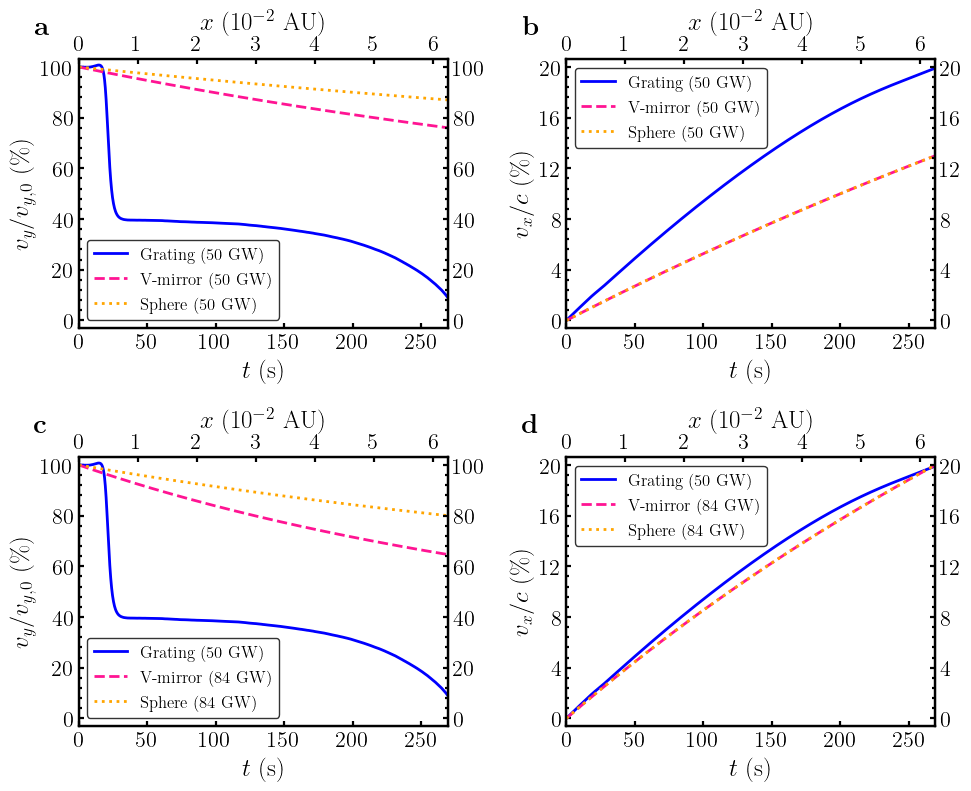

In [3]:
# IMPORTS ################################################################################################################################################################
import scipy
import pickle

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 "text.usetex": True,
                 "font.family": "Computer Modern Roman"})
import matplotlib.ticker as tck


## Plotting font options ##
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



# SAME POWER ################################################################################################################
## Extract data ##
BG_fname = f'./final_data/BG_50GW.pkl'
VM_fname = f'./final_data/VM_50GW.pkl'
SP_fname = f'./final_data/SP_50GW.pkl'

with open(BG_fname, 'rb') as BG_data, open(VM_fname, 'rb') as VM_data, open(SP_fname, 'rb') as SP_data:
    BG_data = pickle.load(BG_data)
    VM_data = pickle.load(VM_data)
    SP_data = pickle.load(SP_data)


## Assign loaded variables ##
v_s = BG_data["Velocity scale"]
_, _, _, vy0 = BG_data["Initial condition"]

# BG
BG_sol = BG_data["Solution"]
BG_t_s = BG_data["Time scale"]
BG_L_s = BG_data["Length scale"]

t = BG_sol.t
BG_x, _, BG_vx, BG_vy = BG_sol.y

# VM
VM_sol = VM_data["Solution"]
VM_L_s = VM_data["Length scale"]

VM_state_tmp = VM_sol.y
VM_state = []
for q in VM_state_tmp:
    q = q[:len(t)]
    VM_state.append(q)
_, _, VM_vx, VM_vy = VM_state

# SP
SP_sol = SP_data["Solution"]
SP_L_s = SP_data["Length scale"]

SP_state_tmp = SP_sol.y
SP_state = []
for q in SP_state_tmp:
    q = q[:len(t)]
    SP_state.append(q)
_, _, SP_vx,SP_vy = SP_state

# Dimensional versions
AU = scipy.constants.au # astronomical unit in metres
t_D = BG_t_s*t
BG_x_D = BG_L_s*BG_x
BG_x_scaledAU = 100*BG_x_D/AU

# Quantities to plot
vy_vy0_perc = [100*BG_vy/vy0, 100*VM_vy/vy0, 100*SP_vy/vy0]
vx_c_perc = [100*BG_vx, 100*VM_vx, 100*SP_vx]
quantities = [vy_vy0_perc, vx_c_perc]


## Plotting vs time ##
# Initialise subplots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,8.2))
axs_ls = list(axs.flatten())

# Options
ax_width = 1.6
l_width = 2

colors = [['blue', 'deeppink', 'orange']]*2
linestyles = [['solid', 'dashed', 'dotted']]*2
leglabels = [["Grating (50 GW)", "V-mirror (50 GW)", "Sphere (50 GW)"]]*2

xlabels = ["$t$ (s)"]*2
x2label = r"$x$ ($10^{-2}$ AU)"
ylabels = [r"$v_y/v_{y,0}$ (\%)", r"$v_x/c$ (\%)"]

ylims = [(-0.03*100,1.03*100), (-0.03*20,1.03*20)]
t_ticks = 6
n_yticks = [6, 6]
n_yminorticks = [5, 5]

# Subplots loop 
ax_count = 0
for ax_idx,ax in enumerate(axs_ls):
    quantity = quantities[ax_idx]
    lcolor = colors[ax_idx]
    ls = linestyles[ax_idx]
    legs = leglabels[ax_idx]

    for q_idx, q in enumerate(quantity):
        ax.plot(t_D,q, linewidth=l_width, color=lcolor[q_idx], linestyle=ls[q_idx], label=legs[q_idx])
    
    ax.set(xlabel=xlabels[ax_idx], ylabel=ylabels[ax_idx])
    ax.set_xlim(t_D[0],t_D[-1])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(t_ticks))

    ax.set_ylim(*ylims[ax_idx])
    ax.yaxis.set_major_locator(plt.MaxNLocator(n_yticks[ax_idx]))
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n_yminorticks[ax_idx]))
    ax.tick_params(which="both", axis='both', width=ax_width, direction='in')
    
    # Second x axis
    xax2 = ax.twiny()
    xax2.set(xlabel=x2label)
    xax2.set_xlim(BG_x_scaledAU[0],BG_x_scaledAU[-1])
    xax2.xaxis.set_major_locator(plt.MaxNLocator(t_ticks+1))
    xax2.tick_params(axis='both', width=ax_width, direction='in')

    # Second y axis
    yax2 = ax.twinx()
    yax2.set_ylim(*ylims[ax_idx])
    yax2.yaxis.set_major_locator(plt.MaxNLocator(n_yticks[ax_idx]))
    yax2.yaxis.set_minor_locator(tck.AutoMinorLocator(n_yminorticks[ax_idx]))
    yax2.tick_params(which="both", axis='both', width=ax_width, direction='in')

    # Legend
    leg = ax.legend(loc='best', prop={'size': 12})
    frame = leg.get_frame()
    frame.set_edgecolor('black')

    # Add label text
    plot_label = f'\\textbf{{{chr(ax_idx+97)}}}'
    ax.text(-0.12, 1.12, plot_label, 
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes,
            fontsize=MEDIUM_SIZE+2)
   
    # change spine width
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(ax_width)
        yax2.spines[axis].set_linewidth(ax_width)

    ax_count += 1
    if ax_count > 1:
        break




# SAME FINAL VELOCITY ################################################################################################################
## Extract data ##
VM_fname = f'./final_data/VM_84GW.pkl'
SP_fname = f'./final_data/SP_84GW.pkl'

with open(VM_fname, 'rb') as VM_data, open(SP_fname, 'rb') as SP_data:
    VM_data = pickle.load(VM_data)
    SP_data = pickle.load(SP_data)


## Assign loaded variables ##
# VM
VM_sol = VM_data["Solution"]
VM_t_s = VM_data["Time scale"]
t_D = VM_t_s*VM_sol.t
_, _, VM_vx, VM_vy = VM_sol.y

# BG
BG_state_tmp = BG_sol.y
BG_state = []
for q in BG_state_tmp:
    q = q[:len(t_D)]
    BG_state.append(q)
BG_x, _, BG_vx, BG_vy = BG_state

# SP
SP_sol = SP_data["Solution"]
_, _, SP_vx,SP_vy = SP_sol.y

# Quantities to plot
vy_vy0_perc = [100*BG_vy/vy0, 100*VM_vy/vy0, 100*SP_vy/vy0]
vx_c_perc = [100*BG_vx, 100*VM_vx, 100*SP_vx]
quantities = [vy_vy0_perc, vx_c_perc]


## Plotting vs time ##
leglabels = [["Grating (50 GW)", "V-mirror (84 GW)", "Sphere (84 GW)"]]*2

# Subplots loop 
for ax_idx_tmp,ax in enumerate(axs_ls):
    if ax_idx_tmp < ax_count:
        continue
    ax_idx = ax_idx_tmp-2

    quantity = quantities[ax_idx]
    lcolor = colors[ax_idx]
    ls = linestyles[ax_idx]
    legs = leglabels[ax_idx]

    for q_idx, q in enumerate(quantity):
        ax.plot(t_D,q, linewidth=l_width, color=lcolor[q_idx], linestyle=ls[q_idx], label=legs[q_idx])
    
    ax.set(xlabel=xlabels[ax_idx], ylabel=ylabels[ax_idx])
    ax.set_xlim(t_D[0],t_D[-1])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.xaxis.set_major_locator(plt.MaxNLocator(t_ticks))

    ax.set_ylim(*ylims[ax_idx])
    ax.yaxis.set_major_locator(plt.MaxNLocator(n_yticks[ax_idx]))
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator(n_yminorticks[ax_idx]))
    ax.tick_params(which="both", axis='both', width=ax_width, direction='in')
    
    # Second x axis
    xax2 = ax.twiny()
    xax2.set(xlabel=x2label)
    xax2.set_xlim(BG_x_scaledAU[0],BG_x_scaledAU[-1])
    xax2.xaxis.set_major_locator(plt.MaxNLocator(t_ticks+1))
    xax2.tick_params(axis='both', width=ax_width, direction='in')

    # Second y axis
    yax2 = ax.twinx()
    yax2.set_ylim(*ylims[ax_idx])
    yax2.yaxis.set_major_locator(plt.MaxNLocator(n_yticks[ax_idx]))
    yax2.yaxis.set_minor_locator(tck.AutoMinorLocator(n_yminorticks[ax_idx]))
    yax2.tick_params(which="both", axis='both', width=ax_width, direction='in')

    # Legend
    leg = ax.legend(loc='best', prop={'size': 12})
    frame = leg.get_frame()
    frame.set_edgecolor('black')

    # Add label text
    plot_label = f'\\textbf{{{chr(ax_idx_tmp+97)}}}'
    ax.text(-0.12, 1.12, plot_label, 
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes,
            fontsize=MEDIUM_SIZE+2)
   
    # change spine width
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(ax_width)
        yax2.spines[axis].set_linewidth(ax_width)



# SAVE FIG ########################################################################################################################
figname = "./Figures/dynamics.pdf"
fig.savefig(figname)

## Figure 6

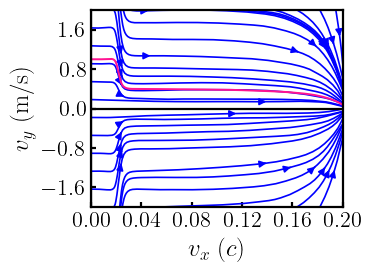

In [5]:
# IMPORTS ################################################################################################################################################################
import numpy as np
import scipy
import pickle

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True,
                 "text.usetex": True,
                 "font.family": "Computer Modern Roman"})
import matplotlib.ticker as tck

from lorentz import gamma_ND, D1_ND
from effderivs import RT


## Plotting font options ##
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



### Parameters/variables ###
## Generic sail ##
m_prime = 1e-3 # sail mass, kg
A_prime = 5 # cross-sectional length of each grating half, m


## Grating ##
# NOTE: the problem is scale invariant, hence most lengths are normalised to grating period (norm. g)
# Insert the params of the optimised grating:
params = [0.816     , 0.39041954, 4.02130915, 5.68395549, 4.78192085,
       2.66302307, 4.99665728, 3.54912938, 3.34141225, 3.64727581,
       3.43302628, 3.01761709, 5.57899187, 1.0416501 , 1.18339218,
       3.24290369, 3.30466197, 2.52785969, 3.22326242, 3.87816428,
       7.16405667, 9.20432867, 4.39680635, 3.96630811, 3.3705581 ,
       2.949805  , 2.93751222, 1.84628246, 1.40812244, 1.56940788,
       5.03176815, 4.48621421]
h = params[1] # grating depth, norm. g
grating_grid = params[2:] # grating permittivities

# Grating numerics parameters
Nx = 30 # Number of grid points
nG = 30 # number of Fourier components to approximate the permittivity profile
Qabs = np.inf # Relaxation parameter

eps_substrate = -1e6 # substrate relative permittivity
substrate_depth = 1 # substrate depth, norm. g
struc_geom = [1,substrate_depth] # structure geometry, norm. g


## Laser ##
I = 5.0e9 # laser intensity, W/m^2
lamfrac_start = params[0] # laser wavelength, norm. g
c = scipy.constants.c # speed of light, m/s


## Dimensional scaling factors ##
# NOTE: x, y, v_x, v_y, v are non-dimensional (ND) during integration
t_s = m_prime*c**2/(I*A_prime) # time scale
L_s = c*t_s # length scale
v_s = c # velocity scale





# TRAJECTORY ############################################################################################################
## Extract data ##
BG_fname = f'./final_data/BG_50GW.pkl'

with open(BG_fname, 'rb') as BG_data:
    BG_data = pickle.load(BG_data)

BG_x0, BG_y0, BG_vx0, BG_vy0 = BG_data["Initial condition"]
BG_sol = BG_data["Solution"]
BG_t_s = BG_data["Time scale"]
BG_L_s = BG_data["Length scale"]
t = BG_sol.t 
BG_x, BG_y, BG_vx, BG_vy = BG_sol.y

# Dimensional versions
AU = scipy.constants.au # astronomical unit in metres
BG_x_D = BG_L_s*BG_x
BG_x_scaledAU = 100*BG_x_D/AU
BG_y_D = BG_L_s*BG_y
BG_vy_D = v_s*BG_vy



# VECTOR FIELD ############################################################################################################
# Grating equation
def sin_thetam(theta,lam,m):
     return np.sin(theta) + m*lam

def cos_thetam(theta,lam,m):
     sin_sq = np.power(sin_thetam(theta,lam,m),2)
     if sin_sq > 1: # avoid evanescence
         return 0
     return np.sqrt(1 - np.power(sin_thetam(theta,lam,m),2))


# Phase diagram range
n_points = 100
xs = np.linspace(0, 1e-2, n_points)
ys = np.linspace(0, 2e-10, n_points)
vxs = np.linspace(0, 0.2, n_points)
vys = np.linspace(-2/c, 2/c, n_points)

dvxdts = np.zeros((n_points,n_points))
dvydts = np.zeros((n_points,n_points))


## Extract state variables ##
for y_idx, vx in enumerate(vxs): # note the switched indices to match xy meshgrid indexing
    for x_idx, vy in enumerate(vys):
        v = [vx,vy]
        vnorm = np.linalg.norm(v)
        theta = -(1/D1_ND(v) - 1)*vy/vnorm


        ## Grating parameters ##
        # Add left and right gratings to form bigrating
        lamfrac = lamfrac_start/D1_ND(v) # incoming wavelength in sail frame
        optimised_params_L = [lamfrac,h] + grating_grid
        optimised_params_R = [lamfrac,h] + grating_grid[::-1]


        ## Efficiencies ##
        # Diffraction
        refl_L = RT(optimised_params_L, struc_geom, Nx, nG, eps_substrate, theta, Qabs)[0]
        refl_R = RT(optimised_params_R, struc_geom, Nx, nG, eps_substrate, theta, Qabs)[0]

        # Radiation pressure
        # Qpr are Cpr divided by cross-sectional area of sail at theta' = 0
        Qprs = np.zeros(4, dtype=np.float32) # Qpr1 and Qpr2 for left and right halves
        orders = np.arange(-1,2,1) # orders according to RT() output
        for order_idx, order in enumerate(orders):
            sin_m = sin_thetam(theta,lamfrac,order)
            cos_m = cos_thetam(theta,lamfrac,order)
            if sin_m >= 1: # if order becomes evanescent
                    sin_m = 0

            Qprs[0] += refl_L[order_idx] * np.cos(theta) * (1 + np.cos(theta)*cos_m - np.sin(theta)*sin_m)
            Qprs[1] += refl_R[order_idx] * np.cos(theta) * (1 + np.cos(theta)*cos_m - np.sin(theta)*sin_m)
            Qprs[2] += -refl_L[order_idx] * np.cos(theta) * (np.sin(theta)*cos_m + np.cos(theta)*sin_m)
            Qprs[3] += -refl_R[order_idx] * np.cos(theta) * (np.sin(theta)*cos_m + np.cos(theta)*sin_m)


        ## Differential equations ##
        # Q1 and Q2 factors are defined for convenience/readability
        Qpr1_Lprime = Qprs[0]
        Qpr1_Rprime = Qprs[1]
        Qpr2_Lprime = Qprs[2]
        Qpr2_Rprime = Qprs[3]
        Q1 = gamma_ND(v) * D1_ND(v)**2 \
            * (Qpr1_Lprime + Qpr1_Rprime + vy/D1_ND(v)*(Qpr2_Lprime + Qpr2_Rprime))
        Q2 = D1_ND(v)**2 \
            * (Qpr2_Lprime + Qpr2_Rprime - vy*gamma_ND(v)*(Qpr1_Lprime + Qpr1_Rprime))

        # RHS functions
        dvxdts[x_idx,y_idx] = 1/gamma_ND(v)**2 * (vx*vy*Q2 - Q1/gamma_ND(v)**2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
        dvydts[x_idx,y_idx] = 1/gamma_ND(v)**2 * (vx*vy*Q1 - Q2) / (gamma_ND(v)**2*vx**2*vy**2 - 1)
 


# PLOTTING ############################################################################################################
fig, ax = plt.subplots(1, figsize=(4,3))

# Options
ax_width = 1.6
l_width = 1.2
x_ticks = 6
y_ticks = 6

# Plot vector field
ax.streamplot(vxs, c*vys, 1/t_s*dvxdts, c/t_s*dvydts, linewidth=l_width, color='blue', density=0.4, broken_streamlines=False)

# Plot solved trajectory
ax.plot(BG_vx, BG_vy_D, linewidth=1.2*l_width, color="deeppink") 

ax.set_xlim((vxs[0],vxs[-1]))
ax.set(xlabel="$v_x$ ($c$)", ylabel="$v_y$ (m/s)")
ax.xaxis.set_tick_params(labelbottom=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(x_ticks))
ax.axvline(0, linewidth=ax_width, color='black')
ax.axhline(0, linewidth=ax_width, color='black')

ax.set_ylim((c*vys[0],c*vys[-1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(y_ticks))
ax.tick_params(which="both", axis='both', width=ax_width, direction='in')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(ax_width)


# SAVE FIG ########################################################################################################################
figname = "./Figures/phase.pdf"
fig.savefig(figname)